#Importing Libraries


In [1]:
import numpy as np 
import pandas as pd 
import os
from tensorflow import keras
from collections import defaultdict
from glob import glob
from random import choice, sample
from tensorflow.keras.preprocessing import image
import cv2
from tqdm import tqdm_notebook
from tqdm import tqdm
import numpy as np
import pandas as pd

from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.layers import Input, Dense, GlobalMaxPool2D, GlobalAvgPool2D, Concatenate, Multiply, Dropout, Subtract, Add
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.layers import Layer, InputSpec
from tensorflow.keras.utils import get_source_inputs
from tensorflow.keras.models import load_model

Installing Keras VGG Face library

In [2]:
!pip install git+https://github.com/rcmalli/keras-vggface.git

  Cloning https://github.com/rcmalli/keras-vggface.git to /tmp/pip-req-build-1zxf1nts
  Running command git clone -q https://github.com/rcmalli/keras-vggface.git /tmp/pip-req-build-1zxf1nts
  Created wheel for keras-vggface: filename=keras_vggface-0.6-py3-none-any.whl size=8325 sha256=d5c92a1613381226b91a703e91fd96c5c7d1f5330dea98c11d208e7278721cd5
  Stored in directory: /tmp/pip-ephem-wheel-cache-gdaz8y8m/wheels/08/df/86/0225d44647ab2256dbf1e006823288fe9cc86367a056e6ea2c
Successfully built keras-vggface


In [3]:
fileName = "/usr/local/lib/python3.7/dist-packages/keras_vggface/models.py"
data = open(fileName).read()
open(fileName, "w+").write(data.replace('keras.engine.topology', 'tensorflow.keras.utils'))

20951

Installing Keras applications and preprocessing modules

In [4]:
!pip install keras_applications

     |████████████████████████████████| 50 kB 4.6 MB/s 


In [5]:
!pip install keras_preprocessing

#Dataset Preprocessing

In [6]:
from keras_vggface.utils import preprocess_input
from keras_vggface.vggface import VGGFace

In [7]:
trainRelationsCSVPath = "/content/train_relationships.csv"
trainPath = "/content/train/"
validationRange = 'F07'

Downloading dataset from Kaggle

In [8]:
from pathlib import Path
if not Path('/mnt/gdrive/My Drive/colab/kaggle.json').exists():
    from google.colab import drive
    drive.mount('/mnt/gdrive')
    !mkdir -p ~/.kaggle
    !cp '/mnt/gdrive/My Drive/kaggle.json'  ~/.kaggle

Mounted at /mnt/gdrive


In [9]:
if not Path('train.zip').exists():
    !kaggle competitions download -c recognizing-faces-in-the-wild

 92% 25.0M/27.1M [00:00<00:00, 111MB/s] 
100% 27.1M/27.1M [00:00<00:00, 107MB/s]
  0% 0.00/33.7k [00:00<?, ?B/s]
100% 33.7k/33.7k [00:00<00:00, 35.5MB/s]
  0% 0.00/354k [00:00<?, ?B/s]
100% 354k/354k [00:00<00:00, 111MB/s]
 98% 29.0M/29.7M [00:00<00:00, 14.5MB/s]
100% 29.7M/29.7M [00:00<00:00, 34.0MB/s]
 84% 94.0M/111M [00:01<00:00, 34.9MB/s]
100% 111M/111M [00:02<00:00, 57.8MB/s] 
  0% 0.00/156k [00:00<?, ?B/s]
100% 156k/156k [00:00<00:00, 163MB/s]
  0% 0.00/77.6k [00:00<?, ?B/s]
100% 77.6k/77.6k [00:00<00:00, 69.2MB/s]
 98% 128M/130M [00:02<00:00, 67.0MB/s]
100% 130M/130M [00:02<00:00, 56.3MB/s]
  0% 0.00/1.47k [00:00<?, ?B/s]
100% 1.47k/1.47k [00:00<00:00, 1.65MB/s]
 79% 27.0M/34.1M [00:00<00:00, 96.9MB/s]
100% 34.1M/34.1M [00:00<00:00, 136MB/s] 
 95% 65.0M/68.6M [00:01<00:00, 30.1MB/s]
100% 68.6M/68.6M [00:01<00:00, 50.7MB/s]
  0% 0.00/8.67k [00:00<?, ?B/s]
100% 8.67k/8.67k [00:00<00:00, 8.95MB/s]


In [10]:
if not Path('train/F0002/MID1').exists():
    !unzip train.zip -d train
    !unzip test.zip -d test

Streaming output truncated to the last 5000 lines.
  inflating: test/face04688.jpg      
  inflating: test/face03972.jpg      
  inflating: test/face02593.jpg      
  inflating: test/face00836.jpg      
  inflating: test/face05284.jpg      
  inflating: test/face03261.jpg      
  inflating: test/face00582.jpg      
  inflating: test/face02696.jpg      
  inflating: test/face05325.jpg      
  inflating: test/face04973.jpg      
  inflating: test/face02902.jpg      
  inflating: test/face06245.jpg      
  inflating: test/face00645.jpg      
  inflating: test/face03284.jpg      
  inflating: test/face00188.jpg      
  inflating: test/face05490.jpg      
  inflating: test/face01683.jpg      
  inflating: test/face05566.jpg      
  inflating: test/face03288.jpg      
  inflating: test/face00045.jpg      
  inflating: test/face06050.jpg      
  inflating: test/face02871.jpg      
  inflating: test/face04507.jpg      
  inflating: test/face01597.jpg      
  inflating: test/face03175.jpg      

Spliiting dataset into train and validation

In [11]:
%%time
allImg = glob(trainPath + "*/*/*.jpg")
trainImg=[x for x in allImg if validationRange not in x]
valImg=[x for x in allImg if validationRange in x]

CPU times: user 81.7 ms, sys: 61.2 ms, total: 143 ms
Wall time: 174 ms


In [12]:
person=[x.split('/')[-3]+'/'+x.split("/")[-2] for x in allImg]

Creating map of person and its images

In [13]:
trainPersonMap = defaultdict(list)
for x in trainImg:
  trainPersonMap[x.split('/')[-3]+'/'+x.split("/")[-2]].append(x)

validationPersonMap = defaultdict(list)
for x in valImg:
  validationPersonMap[x.split('/')[-3]+'/'+x.split('/')[-2]].append(x)

In [14]:
trainRelations = pd.read_csv(trainRelationsCSVPath)
trainRelations = list(zip(trainRelations.p1.values, trainRelations.p2.values))
trainRelations = [x for x in trainRelations if x[0] in person and x[1] in person]

In [15]:
train=[x for x in trainRelations if validationRange not in x[0]]
val=[x for x in trainRelations if validationRange in x[0]]

Utility function for converting input image to np array

In [16]:
def imgVec(path):
  image=cv2.imread(path)
  image=np.array(image).astype(np.float)
  return preprocess_input(image,version=2)

Creating pairs of people to be fed to the model for training

In [17]:
def genFunction(listOfTuples,personMap,batchSize=16):
  person=list(personMap.keys())
  while True:
    batchOfTuples=sample(listOfTuples,batchSize//2)
    labels=[1]*len(batchOfTuples)
    while len(batchOfTuples)<batchSize:
      person1=choice(person)
      person2=choice(person)

      if person1!=person2 and (person1,person2) not in listOfTuples and (person2,person1) not in listOfTuples:
        batchOfTuples.append((person1,person2))
        labels.append(0)
    for x in batchOfTuples:
      if not len(personMap[x[0]]):
        print(x[0])
    chosenPerson1=[choice(personMap[x[0]]) for x in batchOfTuples]
    chosenPerson1=np.array([imgVec(x) for x in chosenPerson1])
    chosenPerson2=[choice(personMap[x[1]]) for x in batchOfTuples]
    chosenPerson2=np.array([imgVec(x) for x in chosenPerson2])

    yield [chosenPerson1,chosenPerson2],np.array(labels)

#Exploratory Data Analysis


In [72]:
%matplotlib notebook
import matplotlib.pyplot as plt

from PIL import Image

In [73]:
train_df = pd.read_csv("/content/train_relationships.csv")
train_df.head()

p1          p2
0  F0002/MID1  F0002/MID3
1  F0002/MID2  F0002/MID3
2  F0005/MID1  F0005/MID2
3  F0005/MID3  F0005/MID2
4  F0009/MID1  F0009/MID4

In [74]:
train_df.shape

(3598, 2)

In [75]:
files = [os.path.join(dp, f) for dp, dn, fn in os.walk(os.path.expanduser("/content/train")) for f in fn]

train_images_df = pd.DataFrame({
    'files': files,
    'IdOfFamily': [file.split('/')[3] for file in files],
    'IdOfKin': [file.split('/')[4] for file in files],
    'distinctId': [file.split('/')[3] + '/' + file.split('/')[4] for file in files]
})
train_images_df.head()

files IdOfFamily IdOfKin  distinctId
0  /content/train/F0258/MID1/P02746_face2.jpg      F0258    MID1  F0258/MID1
1  /content/train/F0258/MID1/P02748_face1.jpg      F0258    MID1  F0258/MID1
2  /content/train/F0258/MID1/P02738_face4.jpg      F0258    MID1  F0258/MID1
3  /content/train/F0258/MID1/P02745_face1.jpg      F0258    MID1  F0258/MID1
4  /content/train/F0258/MID1/P02739_face1.jpg      F0258    MID1  F0258/MID1

In [76]:
print("Count of members in the dataset is : {0}".format(train_images_df["distinctId"].nunique()))
print("Count of families in the dataset is : {0}".format(train_images_df["IdOfFamily"].nunique()))

Count of members in the dataset is : 2316
Count of families in the dataset is : 470


In [77]:
 most_family_pic = train_images_df["IdOfFamily"].value_counts()
most_pic_kin = train_images_df["distinctId"].value_counts()
print("Family id of family with maximum images is : {0}, Image Count: {1}".format(most_family_pic.index[0], most_family_pic[0]))
print("Id of member with max number of images is : {0}, Image Count: {1}".format(most_pic_kin.index[0], most_pic_kin[0]))

Family id of family with maximum images is : F0601, Image Count: 776
Id of member with max number of images is : F0601/MID6, Image Count: 95


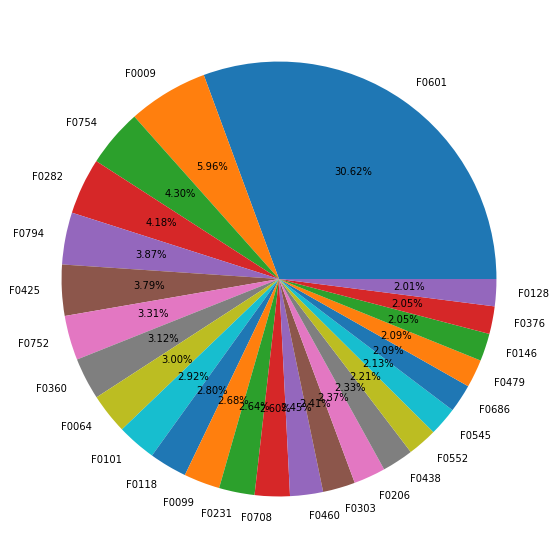

In [78]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
family_series = most_family_pic[:25]
labels = (np.array(family_series.index))
sizes = (np.array((family_series / most_family_pic.sum()) * 100))
%matplotlib inline
import matplotlib.pyplot as plt
f = plt.figure()
f.set_figwidth(10)
f.set_figheight(10)
plt.pie(sizes, autopct='%.2f%%', labels = labels)

plt.show();

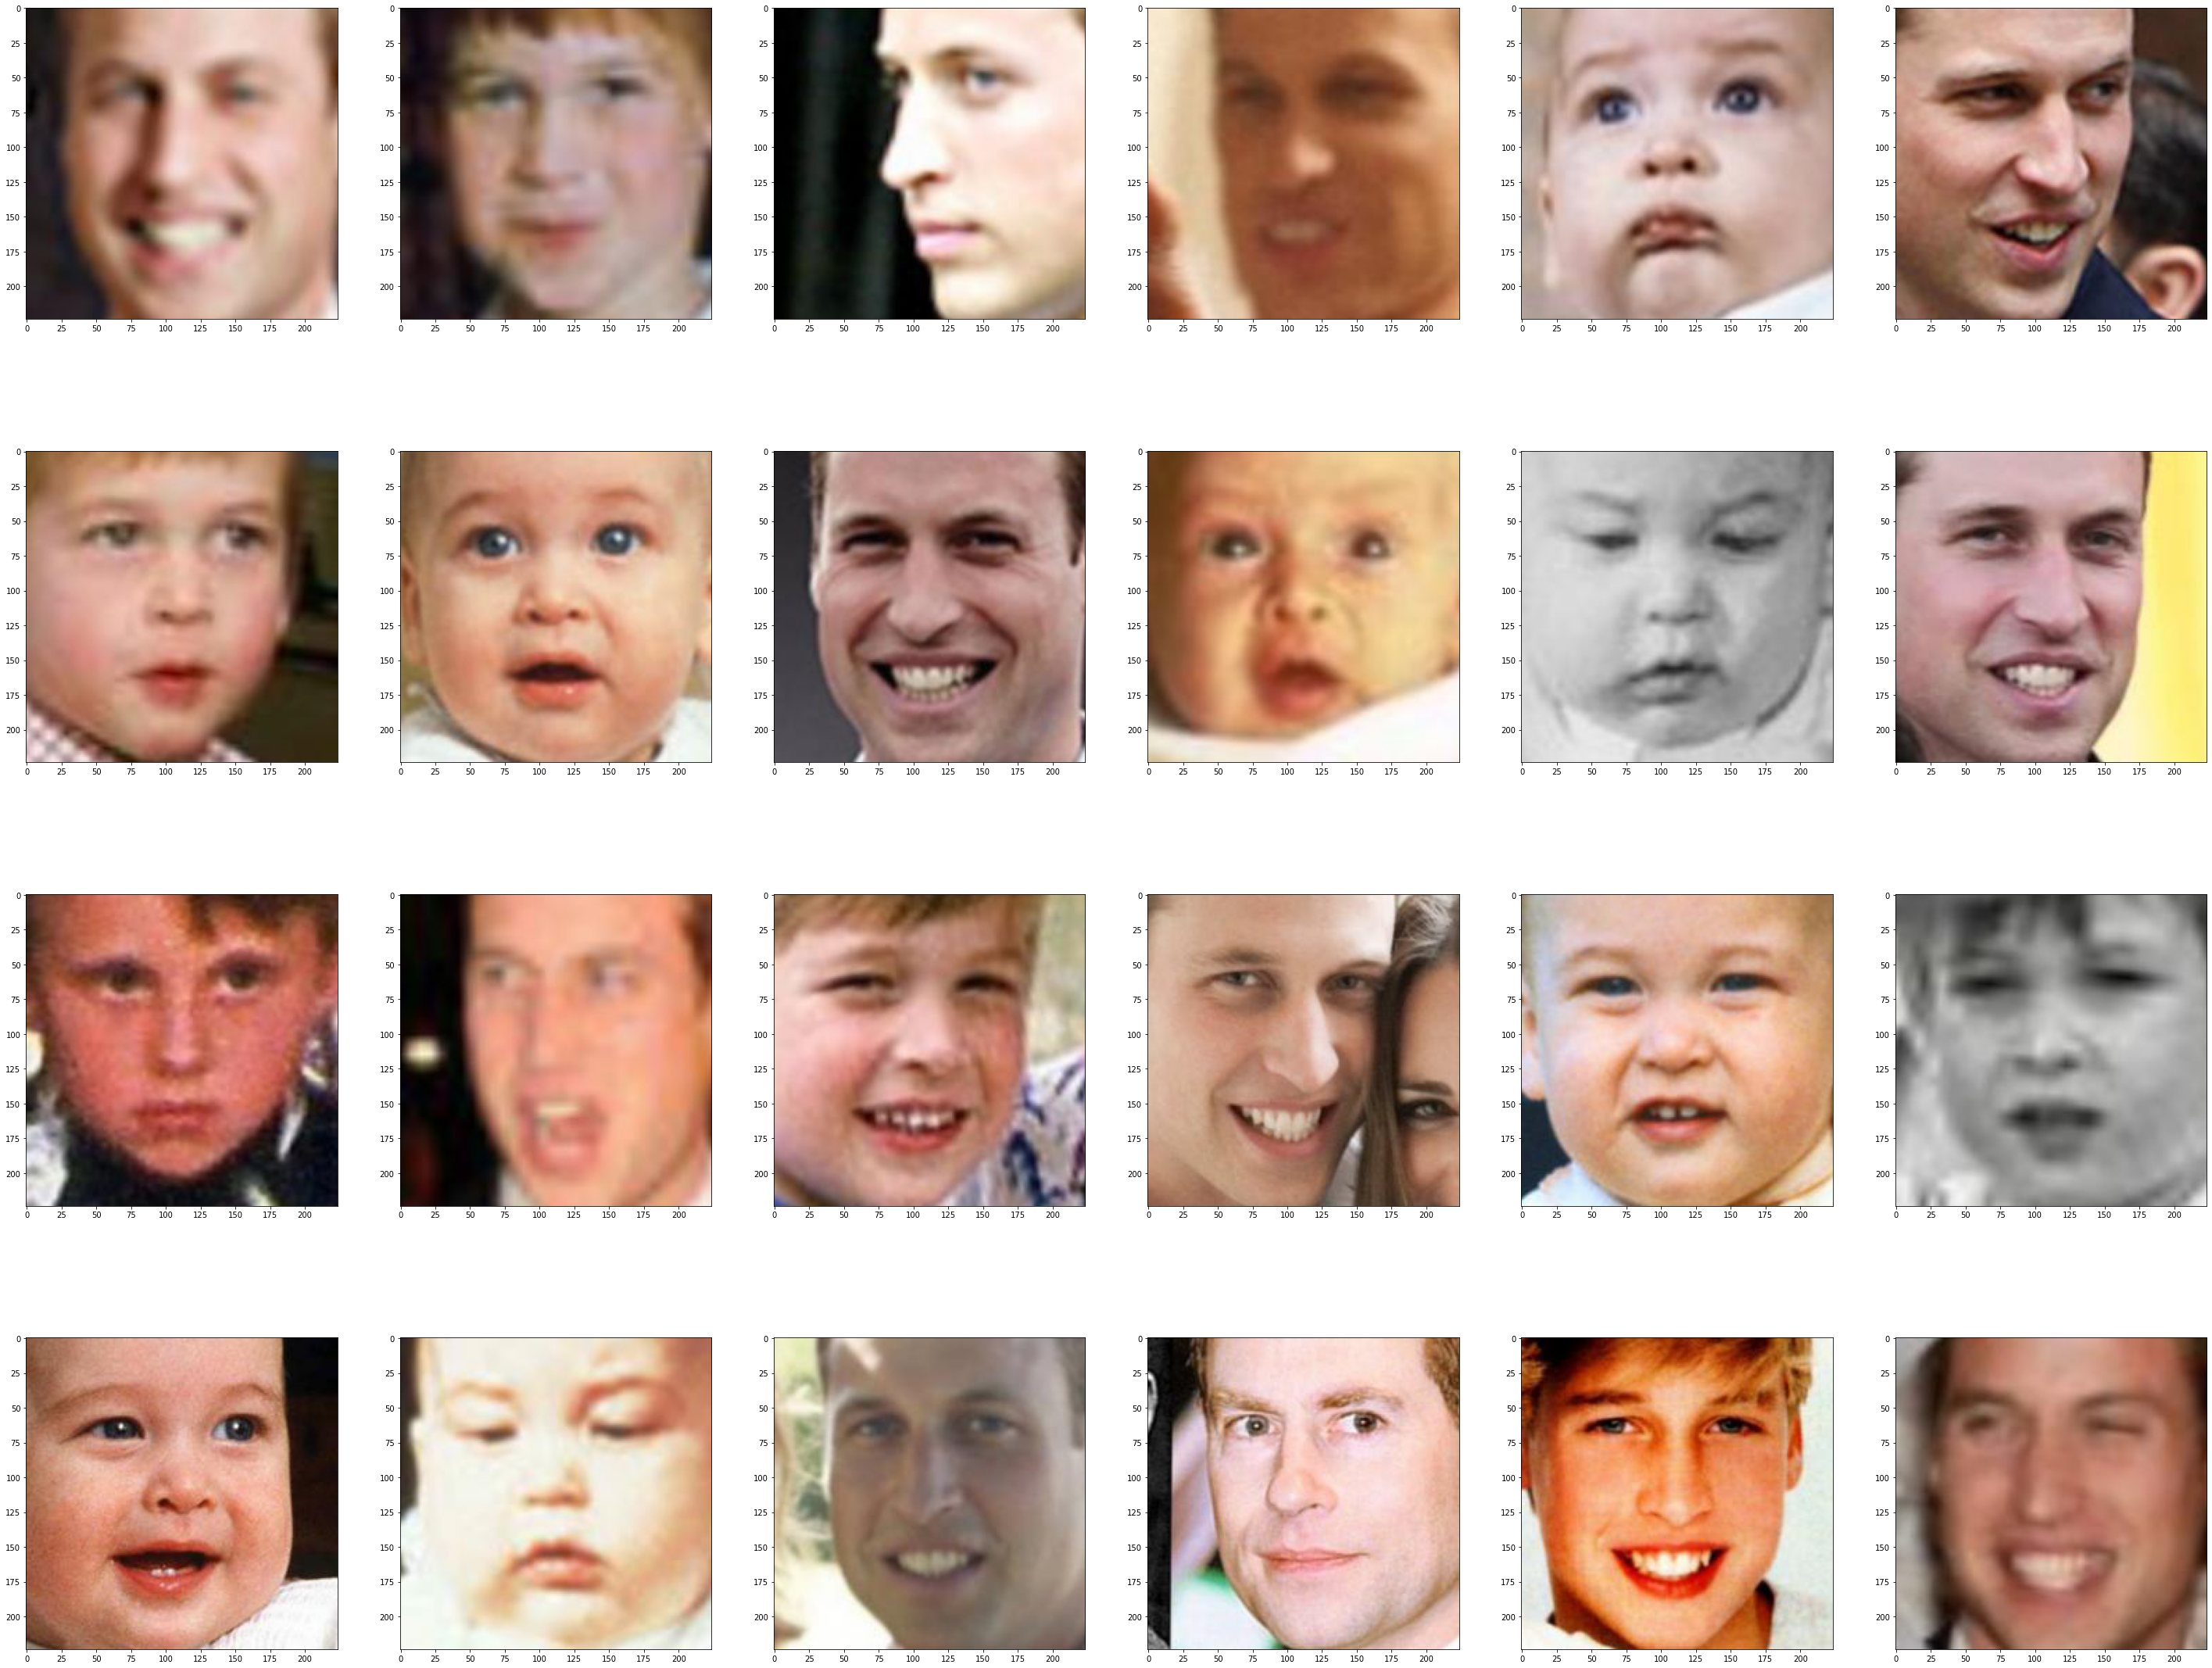

In [79]:
most_pic_members = train_images_df[train_images_df["distinctId"] == most_pic_kin.index[0]].files.values
fig, ax = plt.subplots(4, 6, figsize=(50, 40))
row = 0
col = 0
for index in range(len(most_pic_members[:24])):
    with open(most_pic_members[index], 'rb') as f:
        img = Image.open(f)
        ax[row][col].imshow(img)

        if(col < 5):
            col = col + 1
        else: 
            col = 0
            row = row + 1
fig.show();


In [80]:
most_members_family = train_images_df.groupby("IdOfFamily")["IdOfKin"].nunique().sort_values(ascending=False)
print("Family with maximum number of members: {0}, Number of members: {1}".format(most_members_family.index[0], most_members_family[0]))
print("Family with least number of members: {0}, Number of members: {1}".format(
    most_members_family.index[len(most_members_family)-1], 
    most_members_family[len(most_members_family)-1]))

Family with maximum number of members: F0601, Number of members: 41
Family with least number of members: F0275, Number of members: 1


In [81]:
familylg_df = train_images_df[train_images_df["IdOfFamily"]  == most_members_family.index[0]]
familylg_df.head()

files  ...   distinctId
6714  /content/train/F0601/MID23/P06301_face2.jpg  ...  F0601/MID23
6715  /content/train/F0601/MID23/P06253_face1.jpg  ...  F0601/MID23
6716   /content/train/F0601/MID6/P06399_face1.jpg  ...   F0601/MID6
6717   /content/train/F0601/MID6/P11952_face7.jpg  ...   F0601/MID6
6718   /content/train/F0601/MID6/P04415_face2.jpg  ...   F0601/MID6

[5 rows x 4 columns]

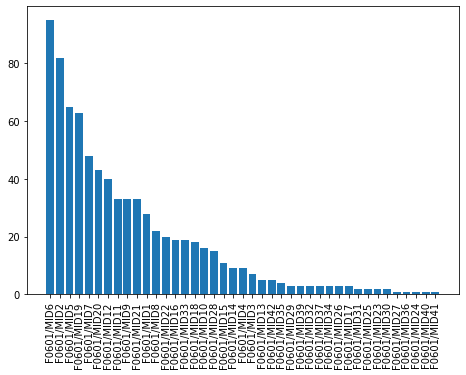

In [82]:
def render_bar_chart(data_df, column_name, title, filename):
    series = data_df[column_name].value_counts()
    count = series.shape[0]
    fig = plt.figure()
    ax = fig.add_axes([0,0,1,1])
    ax.bar(series.index, series.values)
    plt.xticks(range(len(series.index)), series.index, rotation=90)
    
render_bar_chart(familylg_df, 'distinctId', 'Number of pics for members', 'members')

#Defining the Models

Model1

In [18]:
'''
def modelArchitecture():
  img1=Input(shape=(224,224,3))
  img2=Input(shape=(224,224,3))

  baselineModel=VGGFace(model='resnet50',include_top=False)

  for x in baselineModel.layers[:-3]:
    x.trainable=True
  
  imageVec1=baselineModel(img1)
  imageVec2=baselineModel(img2)

  addEmbeddings = Add()([imageVec1 , imageVec2])
  subtractEmbeddings = Subtract()([imageVec1 , imageVec2])

  convOfaddEmbeddings = Conv2D(100 , [1 , 1])(addEmbeddings)
  convOfSubtractEmbeddings = Conv2D(100 , [1 , 1])(subtractEmbeddings)

  concatConv = Concatenate(axis = -1)([convOfaddEmbeddings , convOfSubtractEmbeddings])
  concatConv = BatchNormalization()(concatConv)
  imgVec = Flatten()(concatConv)
  imgVec = Dense(100 , activation="relu")(imgVec)
  imgVec = Dropout(0.3)(imgVec)
  imgVec = Dense(25 , activation="relu")(imgVec)
  imgVec = Dropout(0.3)(imgVec)
  outputImgVec = Dense(1 , activation="sigmoid")(imgVec)

  model=Model([img1,img2],outputImgVec)
  model.compile(loss='binary_crossentropy', 
                  metrics=['acc'], 
                  optimizer=Adam(0.00003))
  model.summary()

  return model
  '''

'\ndef build_model():\n  input1=Input(shape=(224,224,3))\n  input2=Input(shape=(224,224,3))\n\n  base_model=VGGFace(model=\'resnet50\',include_top=False)\n\n  for x in base_model.layers[:-3]:\n    x.trainable=True\n  \n  x1=base_model(input1)\n  x2=base_model(input2)\n\n  addEmbeddings = Add()([x1 , x2])\n  subtractEmbeddings = Subtract()([x1 , x2])\n\n  convOfaddEmbeddings = Conv2D(100 , [1 , 1])(addEmbeddings)\n  convOfSubtractEmbeddings = Conv2D(100 , [1 , 1])(subtractEmbeddings)\n\n  concatConv = Concatenate(axis = -1)([convOfaddEmbeddings , convOfSubtractEmbeddings])\n  concatConv = BatchNormalization()(concatConv)\n  x = Flatten()(concatConv)\n  x = Dense(100 , activation="relu")(x)\n  x = Dropout(0.3)(x)\n  x = Dense(25 , activation="relu")(x)\n  x = Dropout(0.3)(x)\n  out = Dense(1 , activation="sigmoid")(x)\n\n  model=Model([input1,input2],out)\n  model.compile(loss=\'binary_crossentropy\', \n                  metrics=[\'acc\'], \n                  optimizer=Adam(0.00003))\n  

Model2

In [19]:
def modelArchitecture():
  img1=Input(shape=(224,224,3))
  img2=Input(shape=(224,224,3))

  baselineModel=VGGFace(model='resnet50',include_top=False)

  imageVec1=baselineModel(img1)
  imageVec2=baselineModel(img2)

  imageVec1=Concatenate(axis=-1)([GlobalMaxPool2D()(imageVec1),GlobalMaxPool2D()(imageVec1)])
  imageVec2=Concatenate(axis=-1)([GlobalMaxPool2D()(imageVec2),GlobalMaxPool2D()(imageVec2)])

  imageVec3=Subtract()([imageVec1,imageVec2])
  imageVec3=Multiply()([imageVec3,imageVec3])

  modImgVec1=Multiply()([imageVec1,imageVec1])
  modImgVec2=Multiply()([imageVec2,imageVec2])
  imageVec4=Add()([modImgVec1,modImgVec2])

  imageVec5=Multiply()([imageVec1,imageVec2])

  imageVec=Concatenate(axis=-1)([imageVec3,imageVec4,imageVec5])

  imageVec=Dense(100,activation='relu')(imageVec)
  imageVec=Dropout(0.01)(imageVec)
  outputImgVec=Dense(1,activation='sigmoid')(imageVec)

  model=Model([img1,img2],outputImgVec)
  model.compile(loss='binary_crossentropy',metrics=['acc'],optimizer=Adam(0.00001))
  model.summary()

  return model

Model3

In [ ]:
'''
def modelArchitecture():
  img1=Input(shape=(224,224,3))
  img2=Input(shape=(224,224,3))

  baselineModel=VGGFace(model='resnet50',include_top=False)

  for x in baselineModel.layers[:-3]:
    x.trainable=True
  
  imageVec1=baselineModel(img1)
  imageVec2=baselineModel(img2)
  imageVec1=Concatenate(axis=-1)([GlobalMaxPool2D()(imageVec1),GlobalMaxPool2D()(imageVec1)])
  imageVec2=Concatenate(axis=-1)([GlobalMaxPool2D()(imageVec2),GlobalMaxPool2D()(imageVec2)])

  addEmbeddings = Add()([imageVec1 , imageVec2])
  subtractEmbeddings = Subtract()([imageVec1 , imageVec2])

  concatConv = Concatenate(axis = -1)([addEmbeddings , subtractEmbeddings])
  concatConv = BatchNormalization()(concatConv)
  imageVec = Flatten()(concatConv)
  imageVec = Dense(100 , activation="relu")(imageVec)
  imageVec = Dropout(0.3)(imageVec)
  imageVec = Dense(25 , activation="relu")(imageVec)
  imageVec = Dropout(0.3)(imageVec)
  outputImgVec = Dense(1 , activation="sigmoid")(imageVec)

  model=Model([img1,img2],outputImgVec)
  model.compile(loss=[focal_loss(alpha=.25, gamma=2)], 
                  metrics=['acc'], 
                  optimizer=Adam(0.00003))
  model.summary()

  return model
'''

Model4

In [ ]:
'''
def modelArchitecture():
  img1=Input(shape=(224,224,3))
  img2=Input(shape=(224,224,3))

  baselineModel=VGGFace(model='resnet50',include_top=False)

  for x in baselineModel.layers[:-3]:
    x.trainable=True
  
  imageVec1=baselineModel(img1)
  imageVec2=baselineModel(img2)
  imageVec1=Concatenate(axis=-1)([GlobalMaxPool2D()(imageVec1),GlobalMaxPool2D()(imageVec1)])
  imageVec2=Concatenate(axis=-1)([GlobalMaxPool2D()(imageVec2),GlobalMaxPool2D()(imageVec2)])
  
  addEmbeddings = Add()([imageVec1 , imageVec2])
  subtractEmbeddings = Subtract()([imageVec1 , imageVec2])

  concatConv = Concatenate(axis = -1)([addEmbeddings , subtractEmbeddings])
  concatConv = BatchNormalization()(concatConv)
  imageVec = Flatten()(concatConv)
  imageVec = Dense(100 , activation="relu")(imageVec)
  imageVec = Dropout(0.3)(imageVec)
  imageVec = Dense(25 , activation="relu")(imageVec)
  imageVec = Dropout(0.3)(imageVec)
  outputImgVec = Dense(1 , activation="sigmoid")(imageVec)

  model=Model([img1,img2],outputImgVec)
  model.compile(loss='binary_crossentropy', 
                  metrics=['acc'], 
                  optimizer=Adam(0.00003))
  model.summary()

  return model
  '''

Path to save model and its checkpoints

In [22]:
from pathlib import Path
file_path = '/mnt/gdrive/My Drive/KinshipGroup17/vgg_face_resnet_variation.h5'
if not Path(file_path).exists():
  !touch file_path

In [23]:
checkpoint=ModelCheckpoint(file_path,monitor='val_acc',verbose=1,save_best_only=True,mode='max')

In [24]:
reduce_lr_on_plateau=ReduceLROnPlateau(monitor='val_acc',mode='max',factor=0.1,patience=20,verbose=1)

In [25]:
callbacks_list=[checkpoint,reduce_lr_on_plateau]

# Model Training

In [26]:
model=modelArchitecture()
history=model.fit_generator(genFunction(train,trainPersonMap,batchSize=16),\
                    validation_data=genFunction(val, validationPersonMap, batchSize=16),\
                    epochs=100,verbose=1,workers=0,callbacks=callbacks_list,steps_per_epoch=200,validation_steps=100)

94707712/94694792 [==============================] - 5s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 vggface_resnet50 (Functional)  (None, None, None,   23561152    ['input_1[0][0]',                
                             

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


Epoch 1/100
200/200 [==============================] - ETA: 0s - loss: 3.5054 - acc: 0.6019
Epoch 00001: val_acc improved from -inf to 0.59000, saving model to /mnt/gdrive/My Drive/KinshipGroup17/vgg_face_resnet_variation.h5


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


200/200 [==============================] - 88s 347ms/step - loss: 3.5054 - acc: 0.6019 - val_loss: 9.5679 - val_acc: 0.5900 - lr: 1.0000e-05
Epoch 2/100
200/200 [==============================] - ETA: 0s - loss: 1.8251 - acc: 0.6712
Epoch 00002: val_acc improved from 0.59000 to 0.62250, saving model to /mnt/gdrive/My Drive/KinshipGroup17/vgg_face_resnet_variation.h5
200/200 [==============================] - 70s 353ms/step - loss: 1.8251 - acc: 0.6712 - val_loss: 4.9008 - val_acc: 0.6225 - lr: 1.0000e-05
Epoch 3/100
200/200 [==============================] - ETA: 0s - loss: 1.1375 - acc: 0.6928
Epoch 00003: val_acc improved from 0.62250 to 0.62687, saving model to /mnt/gdrive/My Drive/KinshipGroup17/vgg_face_resnet_variation.h5
200/200 [==============================] - 70s 352ms/step - loss: 1.1375 - acc: 0.6928 - val_loss: 2.0578 - val_acc: 0.6269 - lr: 1.0000e-05
Epoch 4/100
200/200 [==============================] - ETA: 0s - loss: 0.7326 - acc: 0.7228
Epoch 00004: val_acc improved

History of model training

In [27]:
history.history

{'acc': [0.6018750071525574,
  0.6712499856948853,
  0.6928125023841858,
  0.7228124737739563,
  0.7309374809265137,
  0.7612500190734863,
  0.778124988079071,
  0.7825000286102295,
  0.7990624904632568,
  0.7853124737739563,
  0.8068749904632568,
  0.8128125071525574,
  0.8209375143051147,
  0.823437511920929,
  0.8278124928474426,
  0.8378124833106995,
  0.839062511920929,
  0.8340625166893005,
  0.8500000238418579,
  0.8556249737739563,
  0.8496875166893005,
  0.8590624928474426,
  0.8628125190734863,
  0.8581249713897705,
  0.8606250286102295,
  0.8668749928474426,
  0.8662499785423279,
  0.8821874856948853,
  0.8709375262260437,
  0.8737499713897705,
  0.8756250143051147,
  0.8768749833106995,
  0.8774999976158142,
  0.8799999952316284,
  0.8887500166893005,
  0.8853124976158142,
  0.8921874761581421,
  0.8799999952316284,
  0.8993750214576721,
  0.903124988079071,
  0.9081249833106995,
  0.8999999761581421,
  0.9112499952316284,
  0.9096875190734863,
  0.8978124856948853,
  0.908

Serialising the model and saving the history file

In [28]:
import pickle
filePath = '/mnt/gdrive/My Drive/KinshipGroup17/vgg_face_variation_history.pkl'
if not Path(filePath).exists():
  !touch filePath

with open('/mnt/gdrive/My Drive/KinshipGroup17/vgg_face_variation_history.pkl','wb') as f:
  pickle.dump(history,f)

INFO:tensorflow:Assets written to: ram://780d89d2-8ef4-4341-9cae-f11fb173a007/assets


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


Saving the model

In [ ]:
filePath = '/mnt/gdrive/My Drive/KinshipGroup17/vggFaceResnetVariationModel.h5'
if not Path(filePath).exists():
  !touch filePath

model.save('/mnt/gdrive/My Drive/KinshipGroup17/vggFaceResnetVariationModel.h5')

Plotting the Training vs Validation accuracy and loss across the epochs

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4))
t = f.suptitle('Model 2 Performance', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)
epoch_list = [i+1 for i in range(100)]

ax1.plot(epoch_list, history.history['acc'], label='Train Accuracy')
ax1.plot(epoch_list, history.history['val_acc'], label='Validation Accuracy')
ax1.set_xticks(np.arange(0, epoch_list[-1], 5))
ax1.set_ylabel('Accuracy Value');ax1.set_xlabel('Epoch');ax1.set_title('Accuracy')
ax1.legend(loc="best");ax1.grid(color='gray', linestyle='-', linewidth=0.5)

ax2.plot(epoch_list, history.history['loss'], label='Train Loss')
ax2.plot(epoch_list, history.history['val_loss'], label='Validation Loss')
ax2.set_xticks(np.arange(0, epoch_list[-1], 5))
ax2.set_ylabel('Loss Value');ax2.set_xlabel('Epoch');ax2.set_title('Loss')
ax2.legend(loc="best");ax2.grid(color='gray', linestyle='-', linewidth=0.5)

#Model Testing

Loading the model for testing

In [31]:
model=load_model('/mnt/gdrive/My Drive/KinshipGroup17/vggFaceResnetVariationModel.h5')

In [32]:
test_path='/content/test/'

In [33]:
submission=pd.read_csv('/content/sample_submission.csv',header=0)

In [34]:
def test_batch(test_pairs,size=32):
  return (test_pairs[pos:pos+size] for pos in range(0,len(test_pairs),size))

Predicting on test data

In [35]:
predictions=[]

for batch in tqdm(test_batch(submission.img_pair.values)):
    X1 = [x.split("-")[0] for x in batch]
    X1 = np.array([imgVec(test_path + x) for x in X1])

    X2 = [x.split("-")[1] for x in batch]
    X2 = np.array([imgVec(test_path + x) for x in X2])

    pred = model.predict([X1, X2]).ravel().tolist()
    predictions += pred

submission['is_related'] = predictions

166it [00:59,  2.81it/s]


In [ ]:
inference = []
for ind in submission.index:
     if submission['is_related'][ind] > 0.7:
       inference.append("Related")
     else:
       inference.append("Not Related")
submission['inference'] = inference

Final Predictions on test data

In [37]:
submission.to_csv("/mnt/gdrive/My Drive/KinshipGroup17/predictions.csv", index=False)
print(submission)

                         img_pair  is_related    inference
0     face05508.jpg-face01210.jpg    0.000705  Not Related
1     face05750.jpg-face00898.jpg    0.928314      Related
2     face05820.jpg-face03938.jpg    0.898290      Related
3     face02104.jpg-face01172.jpg    0.934865      Related
4     face02428.jpg-face05611.jpg    0.574507  Not Related
...                           ...         ...          ...
5305  face99998.jpg-face99993.jpg    0.869307      Related
5306  face99997.jpg-face99996.jpg    0.006975  Not Related
5307  face99997.jpg-face99995.jpg    0.386098  Not Related
5308  face99997.jpg-face99994.jpg    0.974225      Related
5309  face99997.jpg-face99993.jpg    0.404940  Not Related

[5310 rows x 3 columns]
                         img_pair  is_related    inference
0     face05508.jpg-face01210.jpg    0.000705  Not Related
1     face05750.jpg-face00898.jpg    0.928314      Related
2     face05820.jpg-face03938.jpg    0.898290      Related
3     face02104.jpg-face01172.j

End of Code!